In [1]:
%matplotlib inline
import pykat
import pylab as pl
import pandas
import matplotlib.pyplot as plt
import matplotlib
import csv
import math
import numpy as np
from pykat.parallel import parakat
import pprint

pandas.set_eng_float_format(accuracy=3, use_eng_prefix=True)

                                              ..-
    PyKat 1.0.8           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,  
   `^-....____:   +.      www.gwoptics.org/pykat



In [2]:
katfile = './aLIGO_IFO_AWC_tuning_DCoff_maxtem2.kat'
basekat = pykat.finesse.kat()
basekat.loadKatFile(katfile)
# Don't need these things so removing them
#basekat.removeLine("startnode")
#basekat.removeBlock('locks',True)
#basekat.removeBlock('ASuWFS',True)
#basekat.removeBlock('REFLWFS',True)


# Add QM noise detectors
basekat.parseCommands("""
tf sus 1 0 p $mech_fres $mech_Q
const mech_fres 1  # Approx. resonance frequency
const mech_Q    1M # Guess for suspension Q factor

# Differentially modulate the strain in the arms
fsig darm  LXarm 1 0 1
fsig darm2 LYarm 1 180 1

#fsig darm  ETMXHR 1 0 .5
#fsig darm2 ETMYHR 1 180 .5

sq sqz 0 10 0 nsqz

qnoisedS NSR_with_RP    1 $fs nOMC_AROC_trans
#qshotS   NSR_without_RP 1 $fs nOMC_AROC_trans
#qnoised noise    $fs nOMCout
#pd1     signal 1 $fs nOMCout
#pdS3 power $f1 max $f2 max $fs max nOMCout
#pdS sense


xaxis darm f log 5 5k 1000
yaxis log abs
""")

basekat.undumpNodes() #undump the vacuum nodes
kat=basekat.deepcopy() #copy kat code

out = kat.run()

Parsing `put lx1 L $Lmx` into pykat object not implemented yet, added as extra line.
Parsing `put ly1 L $Lmy` into pykat object not implemented yet, added as extra line.
--------------------------------------------------------------
Running kat - Started at 2016-05-18 19:01:44.605130


 94% | ETA:  0:00:02 | Calculating                                             


Finished in 40.4118 seconds


100% | ETA:  0:00:00 | Calculating                                             

In [3]:
pk = parakat() #enable parallel python processing

vary_sqz_ang = []
darm_list = []

kat.sqz.db=10

for i in range(0,90,10):
    f = float(i)
    vary_sqz_ang.append(float(f))
    
for i in range(0,len(vary_sqz_ang),1):
    basekat.undumpNodes()
    kat=basekat.deepcopy()
    vary = float(vary_sqz_ang[i])
    kat.sqz.angle = vary
#    kat.IMFC.R = 1.0-vary
    print(vary)
    pk.run(kat, cmd_args=["-cr=on"])
    #darm_list.append(out['NSR_with_RP'])

outs = pk.getResults()

0.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0


Parallel jobs: 100%|##########################################################|

In [4]:
for i,out in enumerate(outs):
    darm_list.append(outs[i]['NSR_with_RP'])
    
hbar=6.62606957E-34/(2.0 *np.pi)
m = 40.
L = 3994.5
SQL_x = np.sqrt( 8 * hbar / ( m * (2*np.pi*outs[0].x)**2)) / L

In [5]:
vars(kat.sqz.angle)

{'_canFsig': False,
 '_component_name': 'sqz',
 '_isPutable': True,
 '_isPutter': True,
 '_isTunable': True,
 '_name': 'angle',
 '_owner': <weakref at 0x7f878be58f98; to 'pykat.components.squeezer_126' at 0x7f878bd9f898>,
 '_parameter_name': 'angle',
 '_put_name': 'var_sqz_angle',
 '_putter': None,
 '_value': 80.0,
 'put_count': 0,
 'putees': []}

In [6]:
pk.clear()
pk.close()

In [7]:
gwinc_data = np.genfromtxt('./GwincOutput125W.csv', delimiter=',')
headers = ['Freq','MirrorThermal','Newtonian','Quantum','ResGas','Seismic','SuspThermal','Total']

Freq = []
MirrorThermal = []
Newtonian = []
Quantum = []
ResGas = []
Seismic = []
SuspThermal = []
Total = []
for i in range(len(gwinc_data)):
    Freq.append(gwinc_data[i][0])
    MirrorThermal.append(math.sqrt(gwinc_data[i][1]))
    Newtonian.append(math.sqrt(gwinc_data[i][2]))
    Quantum.append(math.sqrt(gwinc_data[i][3]))
    ResGas.append(math.sqrt(gwinc_data[i][4]))
    Seismic.append(math.sqrt(gwinc_data[i][5]))
    SuspThermal.append(math.sqrt(gwinc_data[i][6]))
    Total.append(math.sqrt(gwinc_data[i][7]))
    

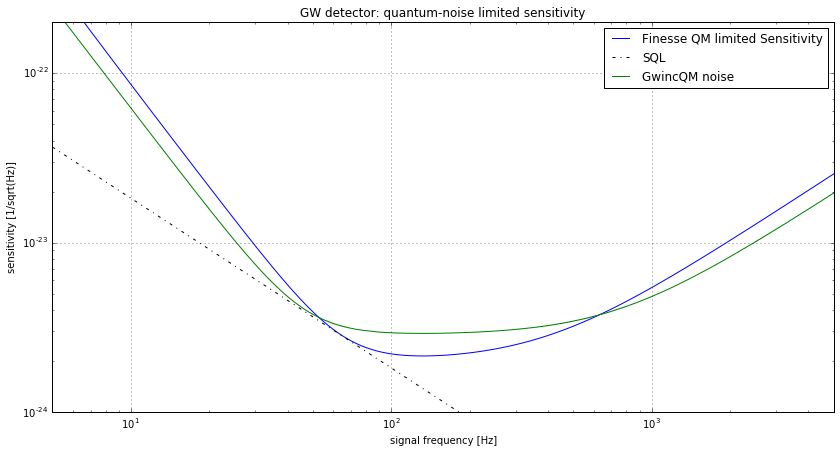

In [8]:
plt.figure(figsize=(14,7))

plt.loglog(out.x,out['NSR_with_RP'], label='Finesse QM limited Sensitivity')
#plt.loglog(out.x,darm_list[2], label='0db')

#plt.loglog(out.x,out['NSR_without_RP'],label='Finesse ShotNoise')
plt.loglog(out.x,SQL_x,'-.',color='k', label='SQL')
#plt.loglog(out.x,out['power'],label='Power on PD')
#plt.loglog(out.x,out['sense'],label='Finesse Total')
plt.loglog(Freq,Quantum,label='GwincQM noise')
#plt.loglog(Freq,Total,label='Gwinc total noise')
plt.title('GW detector: quantum-noise limited sensitivity')
plt.xlabel('signal frequency [Hz]')
plt.xlim([min(out.x),max(out.x)])
plt.ylim([1E-24,2E-22])
plt.legend()
plt.ylabel('sensitivity [1/sqrt(Hz)]')
plt.grid(True)

In [9]:
len(darm_list)

9

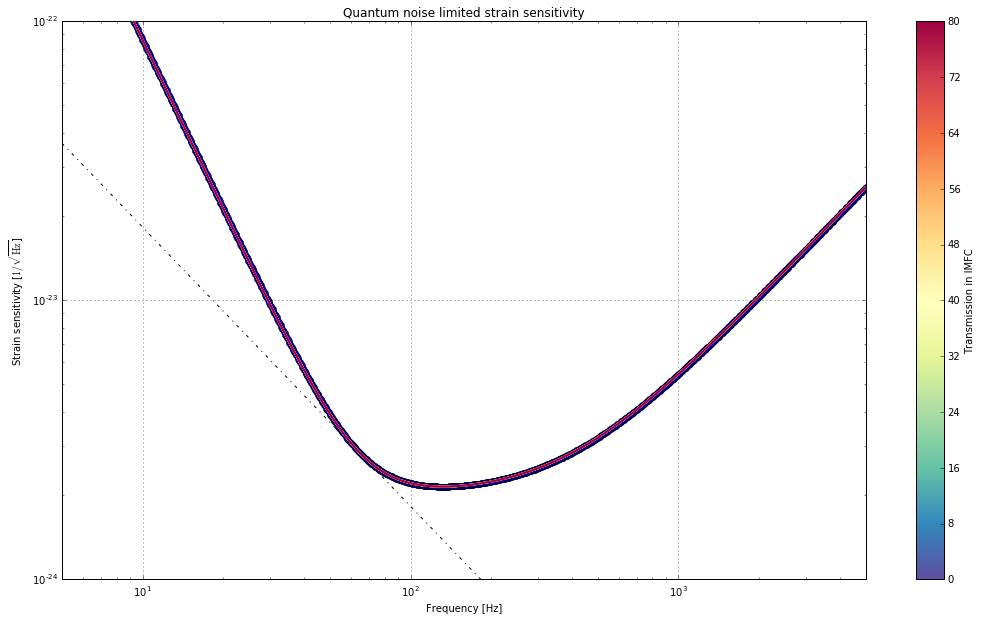

In [10]:
matplotlib.RcParams.update({'font.size', 'Large'})

pl.figure(figsize=(18, 10), dpi=80)

cm = pl.cm.Spectral_r
norm = matplotlib.colors.Normalize(min(vary_sqz_ang),max(vary_sqz_ang))

s_m = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
s_m.set_array([])


for i in range(len(darm_list)):
    c = c = s_m.to_rgba(vary_sqz_ang[i])
    pl.subplot(111)
    pl.loglog(out.x, darm_list[i],linewidth=2,zorder=1000, color = c)
    #pl.pcolormesh(out.x, darm_list[i], vary_fc_T[i], cmap=plt.cm.get_cmap('Blues'))
    
pl.subplot(111)
plt.loglog(outs[0].x,SQL_x,'-.',color='k', label='SQL')
#plt.loglog(Freq,Quantum,'o',label='GwincQM noise')
plt.loglog(out.x,out['NSR_with_RP'],'o', label='Finesse QM limited Sensitivity')

#pl.loglog(out.x, darm_list[0],out.x, darm_list[1],out.x, darm_list[2],out.x, darm_list[3],out.x, darm_list[4], color = c )

pl.title("Quantum noise limited strain sensitivity")
pl.xlim(out.x.min(),out.x.max())
pl.ylim(1E-24,1E-22)
pl.grid(True, zorder=-1)

pl.xlabel("Frequency [Hz]")
pl.ylabel("Strain sensitivity [$1/\\sqrt{\mathrm{Hz}}$]")

cb = pl.colorbar(s_m)
cb.set_label("Transmission in IMFC")
#pylab.savefig("fc_mismatch_to_sqz_ifo_maxtem_%i_sqzing_%g.pdf" % (maxtem, kat.sqz.db))


pl.show()

In [11]:
vary

80.0